In [ ]:
!pip install manga109api
!pip install efficientnet_pytorch

In [ ]:
!unzip src.zip

Archive:  src.zip
replace src/config.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace src/dataset.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace src/loss.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace src/model.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace src/utils.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import torch
import glob
from PIL import Image
import cv2
import manga109api
import torchvision
from torchvision import transforms
from src.model import EfficientDet
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
manga109_root_dir = "/content/drive/MyDrive/Manga109/"
root_dir = "/content/drive/MyDrive/Manga109/save/"
p = manga109api.Parser(root_dir=manga109_root_dir)

In [ ]:
class Manga109Dataset(torch.utils.data.Dataset):
    def __init__(self, root, manga109_root_dir, transforms):
        self.root = root
        self.transforms = transforms
        self.parser = manga109api.Parser(root_dir=manga109_root_dir)
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.
        width, height, _ = img.shape
        h_scale, w_scale = width/512, height/512
        splitted = self.imgs[idx].split("_")
        book = "_".join(splitted[:-1])
        page_index = splitted[-1]
        page_index, extension = page_index.split(".")
        page_index = int(page_index)
        annotation = p.get_annotation(book=book)
        boxes = []
        rois = annotation["page"][page_index]["text"]
        for roi in rois:
            xmin = roi["@xmin"] 
            xmax = roi["@xmax"] 
            ymin = roi["@ymin"] 
            ymax = roi["@ymax"] 
            boxes.append([xmin/w_scale, ymin/h_scale, xmax/w_scale, ymax/h_scale, 1])
            #boxes.append([xmin, ymin, xmax, ymax, 1])
        
        for i in range(55 - len(boxes)):
            boxes.append([-1, -1, -1, -1, -1])
        
        target = np.array(boxes).astype(np.float32)
        #img = Image.open(p.img_path(book=book, index=page_index))
        img = torch.from_numpy(img)
        img = img.permute(2, 0, 1)
        #sample = {'img': img, 'annot': target}
        if self.transforms:
            sample = self.transforms(img)
            
        return sample, target, h_scale, w_scale

    def __len__(self):
        return len(self.imgs)

In [ ]:
transform= transforms.Compose([transforms.Resize((512,512)), transforms.Normalize(0,1)])

dataset = Manga109Dataset(root_dir, manga109_root_dir, transform)
train_dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [ ]:
PATH = "/content/drive/MyDrive/Manga109/mangadet.pth"

In [ ]:
model = EfficientDet(num_classes = 2)
if torch.cuda.is_available():
  model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
model.load_state_dict(torch.load(PATH))

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

In [ ]:
loss_hist = []
epochs = 2
for epoch in range(epochs):
  batch_loss = 0
  for c, sample in enumerate(tqdm(train_dataloader)):
    optimizer.zero_grad()
    img = sample[0].double()
    annot = sample[1]
    if torch.cuda.is_available():
        img = img.cuda()
        annot = annot.cuda()
    losses = model([img,annot])
    loss = losses[0] + losses[1]
    batch_loss += loss.item()
    loss.backward()
    optimizer.step()
    if c%100 == 0:
      torch.save(model.state_dict(), PATH)
      loss_hist.append(batch_loss)
      batch_loss = 0

  0%|          | 0/999 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  0%|          | 0/999 [00:00<?, ?it/s]

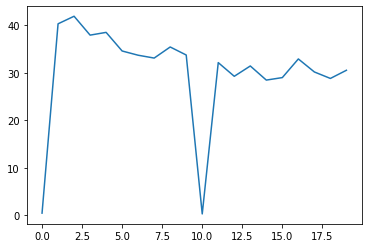

In [ ]:
plt.plot(loss_hist)

In [ ]:
torch.save(model.state_dict(), PATH)

In [ ]:
sample = next(iter(train_dataloader))
img = sample[0].permute(0, 2, 3, 1).cpu().numpy()[0]
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for co in sample[1][0]:
    color = (255, 0, 0)
    thickness = 2
    start_point = (int(co[0]), int(co[1]))
    end_point = (int(co[2]), int(co[3]))
    img = cv2.rectangle(img, start_point, end_point, color, thickness)
plt.figure(figsize=(8,8)) 
plt.imshow(img)